<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumArmsClassifier_20_Spacy_Textcat_First10Pages_fewer_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-11-18 14:18:35.250705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 14:18:40.543626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


In [2]:
df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [ ]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [4]:

texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 10:
      pages = pages[:10]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [5]:
 del file_to_pages

In [6]:
df_annotations = df_annotations[~df_annotations.num_arms.isna()]

In [7]:
df_annotations["num_arms"].value_counts()

2.0     5228
1.0     3086
3.0     1456
4.0      908
5.0      315
6.0      251
7.0       83
8.0       80
9.0       58
10.0      31
12.0      27
11.0      17
13.0      10
14.0       8
15.0       7
18.0       5
16.0       4
20.0       3
17.0       3
23.0       2
21.0       2
29.0       1
19.0       1
34.0       1
38.0       1
30.0       1
40.0       1
22.0       1
Name: num_arms, dtype: int64

In [8]:
for i in np.quantile(df_annotations["num_arms"], [0, 0.2, 0.4, 0.6, 0.8, 1]):
  print (int(np.float(i)))

1
1
2
2
3
40


/tmp/ipykernel_241877/1062825910.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print (int(np.float(i)))


In [9]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 3:
        return "3+"
    return str(int(num))
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

In [10]:
df_annotations["num_arms_clean"].value_counts()

2     5228
3+    3277
1     3086
Name: num_arms_clean, dtype: int64

In [11]:
labels = list(sorted(set(df_annotations["num_arms_clean"]), key =lambda x : int(re.sub(r'\D.*', '', x))))
labels

['1', '2', '3+']

In [ ]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.num_arms_clean.iloc[idx]):
    continue
  cats[df_annotations.num_arms_clean.iloc[idx]] = 1
  doc.cats = cats

  docs_list.add(doc)

0 11591
100 11591
200 11591
300 11591
400 11591
500 11591
600 11591
700 11591
800 11591
900 11591
1000 11591
1100 11591
1200 11591
1300 11591
1400 11591
1500 11591
1600 11591
1700 11591
1800 11591
1900 11591
2000 11591
2100 11591
2200 11591
2300 11591
2400 11591
2500 11591
2600 11591
2700 11591
2800 11591
2900 11591
3000 11591
3100 11591
3200 11591
3300 11591
3400 11591
3500 11591
3600 11591
3700 11591
3800 11591
3900 11591
4000 11591
4100 11591
4200 11591
4300 11591
4400 11591
4500 11591
4600 11591
4700 11591
4800 11591
4900 11591
5000 11591
5100 11591
5200 11591
5300 11591
5400 11591
5500 11591
5600 11591
5700 11591
5800 11591
5900 11591
6000 11591
6100 11591
6200 11591
6300 11591
6400 11591
6500 11591
6600 11591
6700 11591
6800 11591
6900 11591
7000 11591
7100 11591
7200 11591
7300 11591
7400 11591
7500 11591
7600 11591
7700 11591
7800 11591
7900 11591
8000 11591
8100 11591
8200 11591
8300 11591
8400 11591
8500 11591
8600 11591
8700 11591
8800 11591
8900 11591
9000 11591
9100 11591


In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/arms_20_train.spacy


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/arms_20_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
!ls /content/drive/MyDrive/data/arms_20_train.spacy

train_doc_bin0.spacy  train_doc_bin4.spacy  train_doc_bin8.spacy
train_doc_bin1.spacy  train_doc_bin5.spacy  train_doc_bin9.spacy
train_doc_bin2.spacy  train_doc_bin6.spacy
train_doc_bin3.spacy  train_doc_bin7.spacy


In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/arms_20_dev.spacy")

In [ ]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_arms_20 --paths.train /content/drive/MyDrive/data/arms_20_train.spacy --paths.dev  /content/drive/MyDrive/data/arms_20_dev.spacy --gpu-id 0

✔ Created output directory:
/content/drive/MyDrive/data/output_arms_20
ℹ Saving to output directory:
/content/drive/MyDrive/data/output_arms_20
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-18 10:56:48,354] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-18 10:56:48,365] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-18 10:56:48,368] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-18 10:56:48,369] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-11-18 11:06:35,178] [INFO] Initialized pipeline components: ['textcat']
INFO:spacy:Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.0
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------


In [ ]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_arms_20/model-best")

In [12]:
import spacy
nlp = spacy.load("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk/front_end/models/spacy-textcat-arms-20-model-best")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [13]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [14]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [15]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [16]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/tmp/ipykernel_241877/487073676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["y_pred"] = [max(p, key=p.get) for p in predictions]


In [17]:
num_arms_ground_truths = df_val.num_arms_clean
pred_num_arms = df_val["y_pred"]

In [18]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.5160984848484849


''

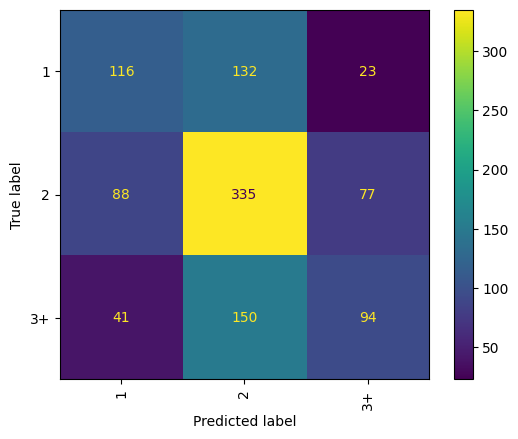

In [19]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms, labels=labels)
plt.xticks(rotation=90)
;

In [20]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(num_arms_ground_truths == i, [p[i] for p in predictions])
  print (f"Num arms ROC AUC {roc_auc} for {i} arms")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Num arms ROC AUC 0.6972524502315086 for 1 arms
Num arms ROC AUC 0.6149460431654676 for 2 arms
Num arms ROC AUC 0.6531412838191457 for 3+ arms
Average 0.6551132590720407


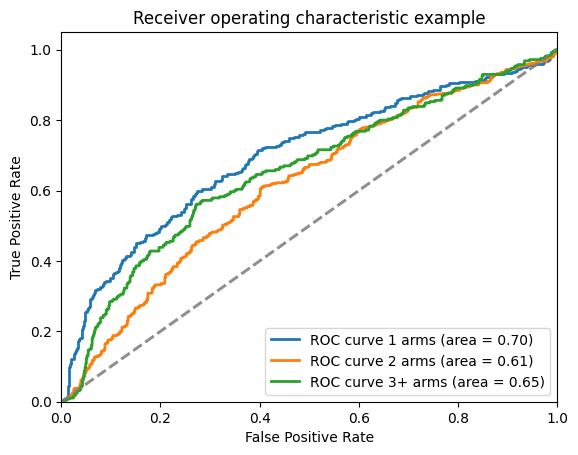

In [21]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(num_arms_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} arms (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()